# Lab: Support Vector Machine
Train a SVM for an AI task

**Requirements**

`Requirement 1`: Choose a SVM with any Kernel of your choice. While not obligatory, opting for either from-scratch implementation or using advanced techniques from a research paper will receive higher evaluation.

`Requirement 2`: Choose a Machine Learning Task of your choice: Regression, Classification

`Requirement 3`: Choose any dataset of your choice

`Requirement 4`: Apply EDA and Pre-processing. Your extracted features, plots, or insights need to be directly related to why it helps your SVM Algorithm peform better

`Requirement 5`: Train and Predict with your SVM

`Requirement 6`: Evaluate your SVM metrics

`Requirement 7`: Compare your SVM with another algorithm or from a different kernel and explain why one is better or worse.

**Scoring Criteria**

You will be graded based on Originality of your implementation: Did you implement anything new in the model or just re-use it? How much work did you put into implementing your model? Result of your implementation: Accuracy, Loss, Cross-validation. Q/A to test your understanding: How well do you understand your code? How well do you understand Machine Learning concepts? Note: DO NOT add comments in your code

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dask import bag, diagnostics
import seaborn as sn
from PIL import Image

## Preprocess Data

### EDA

Text(0, 0.5, '# Images')

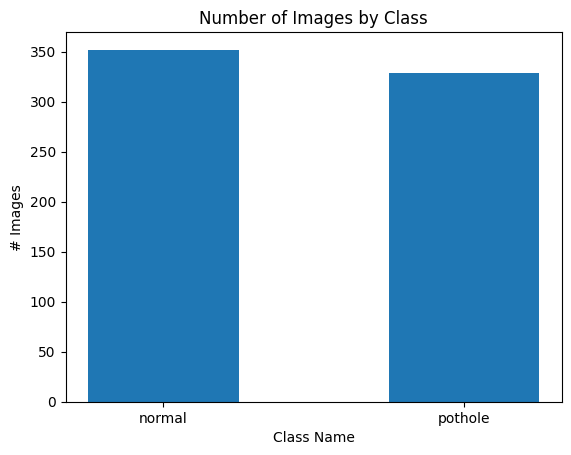

In [11]:
data_path = "./data/pothole/"
number_classes = {
    'normal': len(os.listdir(data_path + "normal")),
    'pothole': len(os.listdir(data_path + "potholes"))
}

plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')

In [18]:
def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    with Image.open(file) as img:
        width, height = img.size
    
    return height, width

[########################################] | 100% Completed | 330.45 ms
[########################################] | 100% Completed | 562.14 ms


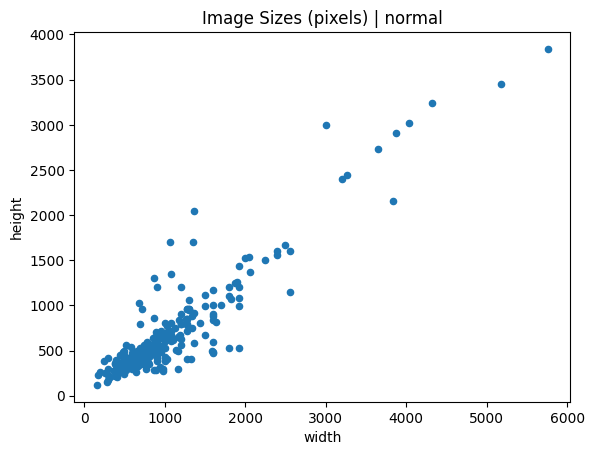

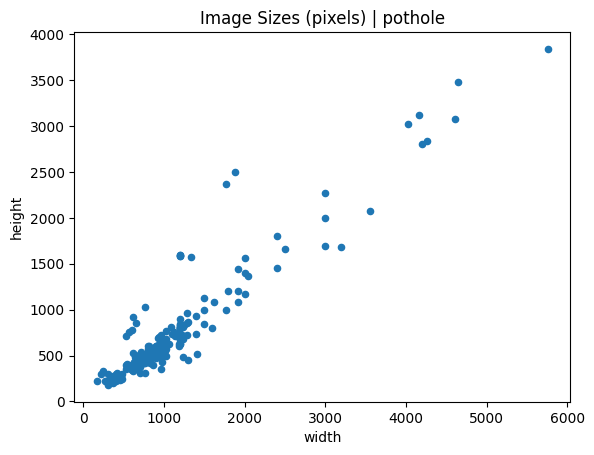

In [19]:
data_path = "./data/pothole/"

directories = {
    'normal': data_path + "normal/",
    'pothole': data_path + "potholes/"
}

image_extensions = ['.jpg', '.jpeg', '.png']

for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)

    with diagnostics.ProgressBar():
        dims = dims.compute()

    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height')
    plt.title('Image Sizes (pixels) | {}'.format(n))

### Load Image

In [21]:
def load_data(data_path: str):
    input_img, input_label = [], []
    resize = (224, 224)

    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            img_path = os.path.join(dirname, filename)
            img_label = dirname.split("/")[-1]
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                input_img.append(cv2.resize(img, resize))
                if img_label == "normal":
                    input_label.append(0)
                else:
                    input_label.append(1)
            except:
                print(img_path)
    return np.array(input_img), np.array(input_label)

In [ ]:
input_img, input_label = load_data(data_path="./data/pothole")

./data/pothole/.DS_Store
./data/pothole/normal/226.jpg


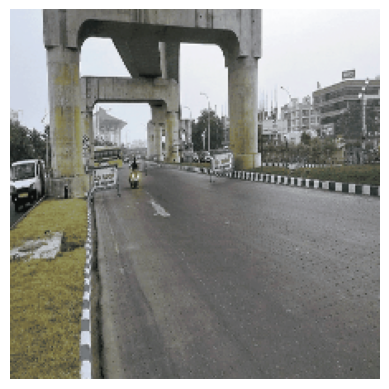

In [ ]:
from PIL import Image

img = Image.open("./data/pothole/normal/226.jpg").convert("RGB")
img = np.array(img)
plt.imshow(cv2.resize(img, (224, 224)))
plt.axis("off")
plt.show()

In [ ]:
img = Image.open("./data/pothole/normal/226.jpg").convert("RGB")
img = np.array(img)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)

img_lbl = np.array([0])
input_img = np.append(input_img, img, axis = 0)
input_label = np.append(input_label, img_lbl, axis = 0)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(input_img, input_label, test_size=0.2)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

### Data Augmentation

In [ ]:
def append_img(input_img: str, input_label: str, img_iterator):
    input_label_n = input_label.copy()
    input_img_n = input_img.copy()

    for i in range(len(img_iterator)):
        img = img_iterator[i]
        img = img.astype("uint8")

        img_lbl = [input_label[i]]
        input_img_n = np.append(input_img_n, img, axis = 0)
        input_label_n = np.append(input_label_n, img_lbl, axis = 0)
    return input_img_n, input_label_n

In [ ]:
# Flipping
# flip_data_generator = ImageDataGenerator(horizontal_flip = True)
# img_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
# input_img_n, input_label_n = append_img(train_x, train_y, img_iterator)

# Rotation - 30 deg 
# rotate_data_generartor = ImageDataGenerator(rotation_range = 30)
# im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
# input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

# Rotation - -30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 330)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

In [ ]:
input_img_n, input_label_n = train_x, train_y

((544, 224, 224, 3), (137, 224, 224, 3), (544,), (137,))

## Model

In [ ]:
# # Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_img_n, test_x
train_x = input_img_n.reshape((input_img_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1)) 
test_y = test_y.reshape((test_y.shape[0], 1))

In [ ]:
# scaler = StandardScaler()
# scaler.fit(train_x)

# train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)

### SVM

In [ ]:
# hyper_params = clf.best_params_
svmClassifier = SVC(C=2, kernel="rbf")

svmClassifier.fit(train_x, train_y.ravel())
pred_y = svmClassifier.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(accuracy)

0.9124087591240876


### SVM With PCA Performance

In [ ]:
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.1904253  0.31172912 0.36445285 ... 1.         1.         1.        ]


In [ ]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

In [ ]:
# Test set
svmClassifier = SVC(C=2, kernel = "rbf")
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
accuracy = accuracy_score(test_y, pred_y)
print(accuracy)

0.8905109489051095


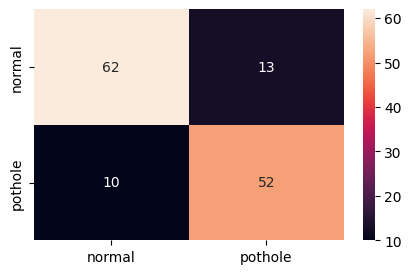

In [ ]:
array = confusion_matrix(test_y, pred_y)
label = ["normal", "pothole"]
df_cm = pd.DataFrame(array, index = label, columns = label)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
plt.show()

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1000)
logistic.fit(train_x_pca, train_y.ravel())
pred_y = logistic.predict(test_x_pca)
accuracy = accuracy_score(test_y, pred_y)
print(accuracy)

/Users/ledinhnguyen/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8321167883211679


#### CNN

In [ ]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential

# Convolutional Neural Network - Modified from AlexNet
def CNN():
    CNN_model = Sequential()
    
    CNN_model.add(Conv2D(filters = 96, input_shape = (224, 224, 3), kernel_size = (11, 11), strides = (4, 4), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Conv2D(filters = 256,  kernel_size = (5, 5), strides = (1, 1), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Flatten())
    CNN_model.add(Dense(512))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(256))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(1, activation = 'sigmoid'))
    
    return CNN_model

# Compile Model
cnn_model = CNN()
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [ ]:
# Training Model
cnn_model.fit(train_x_nn/255, train_y, batch_size = 256, epochs = 50, verbose = 1)

Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 1.1253 - accuracy: 0.4871
Epoch 2/50
5/5 [==============================] - 8s 2s/step - loss: 0.6987 - accuracy: 0.4816
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 0.6746 - accuracy: 0.6369
Epoch 4/50
5/5 [==============================] - 9s 2s/step - loss: 0.6499 - accuracy: 0.5809
Epoch 5/50
5/5 [==============================] - 9s 2s/step - loss: 0.5649 - accuracy: 0.6976
Epoch 6/50
5/5 [==============================] - 9s 2s/step - loss: 0.5100 - accuracy: 0.7298
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 0.4873 - accuracy: 0.7537
Epoch 8/50
5/5 [==============================] - 9s 2s/step - loss: 0.4614 - accuracy: 0.7803
Epoch 9/50
5/5 [==============================] - 8s 2s/step - loss: 0.4012 - accuracy: 0.8318
Epoch 10/50
5/5 [==============================] - 9s 2s/step - loss: 0.3319 - accuracy: 0.8621
Epoch 11/50
5/5 [==============================]

In [ ]:
print(cnn_model.metrics_names)
print(cnn_model.evaluate(test_x_nn/255, test_y, verbose = 0))

['loss', 'accuracy']
[0.5418282747268677, 0.9197080135345459]


# Advanced: Using a pre_trained CNN model for feature extraction to improve the SVMs

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

def load_data(data_path: str):
    input_img, input_label = [], []
    resize = (224, 224)

    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            img_path = os.path.join(dirname, filename)
            img_label = dirname.split("/")[-1]
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                input_img.append(cv2.resize(img, resize))
                if img_label == "normal":
                    input_label.append(0)
                else:
                    input_label.append(1)
            except:
                print(img_path)
    return np.array(input_img), np.array(input_label)

# Load images using your function
data_path = "./data/pothole/"
images, labels = load_data(data_path)

./data/pothole/.DS_Store
./data/pothole/normal/226.jpg


In [2]:
images[0].shape

(224, 224, 3)

In [3]:
# Step 1: Pre-trained CNN (VGG16) feature extraction
def extract_cnn_features(img_array):
    model = VGG16(weights='imagenet', include_top=False)
    img_array = preprocess_input(img_array)
    
    # Expand dimensions to match VGG16 input shape
    img_array = np.expand_dims(img_array, axis=0)

    cnn_features = model.predict(img_array)
    cnn_features_flattened = cnn_features.flatten()

    return cnn_features_flattened


# Step 2: HOG feature extraction (optional)
def extract_hog_features(image_data):
    hog_features = feature.hog(image_data[:, :, 0], orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    return hog_features

# Step 3: Combine CNN and HOG features
def combine_features(cnn_features, hog_features):
    combined_features = np.concatenate((cnn_features, hog_features))
    return combined_features

# Loop through images and extract features
feature_vectors = []
for image_data, label in zip(images, labels):
    # Convert to uint8 for HOG processing (if using HOG)
    image_data = (image_data * 255).astype(np.uint8)

    # Step 1: Extract CNN features
    cnn_features = extract_cnn_features(image_data)

    # Step 2: Extract HOG features (optional)
    hog_features = extract_hog_features(image_data)

    # Step 3: Combine features
    combined_features = combine_features(cnn_features, hog_features)
    feature_vectors.append(combined_features)

# Convert to numpy array for training
features = np.array(feature_vectors)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 4: Train SVM
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


1/1 [==============================] - 0s 133ms/step
Accuracy: 0.9705882352941176


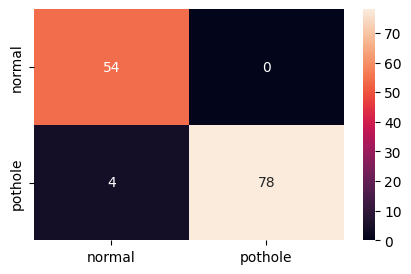

In [7]:
array = confusion_matrix(y_test, y_pred)
label = ["normal", "pothole"]
df_cm = pd.DataFrame(array, index = label, columns = label)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
plt.show()

In [25]:
images.shape, labels.shape

((680, 224, 224), (680,))